In [60]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
supported_drivers['KML'] = 'rw'
import shapely.speedups
shapely.speedups.enable()

Creating the file paths necessary to create data.

In [61]:
fires_file = 'raw_data/H_FIRE_PNT.csv'
shape_file = 'raw_data/BC_Regional_Districts.kml'
labels_file = 'raw_data/labels.csv'
weather_station_file = 'raw_data/weather_stations_coordinates.csv'
region_area = 'raw_data/area/hand_cleaned_area.csv'

In [62]:
labels = pd.read_csv(labels_file)

In [63]:
polys = gpd.read_file(shape_file, driver='KML')

In [123]:
df = pd.read_csv(fires_file)

/var/folders/f9/9vn_4nrs38q_5092cm0ssfhm0000gn/T/ipykernel_40132/1511561435.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fires_file)


In [65]:
loc = pd.read_csv(weather_station_file)

In [66]:
area = pd.read_csv(region_area)

The cells below take only the data of interest, create Year and Month columns, and take only Fires occuring after 2000.

In [67]:
df['Year'] = df['IGN_DATE'].astype(str).str[:4]
df['Month'] = df['IGN_DATE'].astype(str).str[4:6]
df = df[df['FIRE_TYPE'] == 'Fire']
df = df[df['Year'].astype(float) > 2000].reset_index(drop=True)

In [68]:
data = df[['FIRE_CAUSE', 'LATITUDE', 'LONGITUDE', 'SIZE_HA', 'Year', 'Month']]

In [119]:
data

,FIRE_CAUSE,LATITUDE,LONGITUDE,SIZE_HA,Year,Month,Weather City,points,Region Name,Region Number
0,Lightning,52.7163,-120.8649,0.009,2014,08,Williams Lake,POINT (-120.86490 52.71630),Cariboo,41.0
1,Lightning,51.3333,-120.8167,0.009,2003,07,Williams Lake,POINT (-120.81670 51.33330),Thompson-Nicola,33.0
2,Person,55.7837,-120.9953,2.500,2003,09,Dawson Creek,POINT (-120.99530 55.78370),Peace River,55.0
3,Lightning,51.1633,-118.9430,0.009,2007,07,Nakusp,POINT (-118.94300 51.16330),Columbia-Shuswap,39.0
4,Lightning,54.8516,-127.6553,0.009,2009,07,Smithers,POINT (-127.65530 54.85160),Bulkey-Nechako,51.0
...,...,...,...,...,...,...,...,...,...,...
35006,Person,49.3728,-116.0612,29.000,2021,07,Sparwood,POINT (-116.06120 49.37280),East Kootenay,1.0
35007,Lightning,48.5600,-124.2433,0.300,2021,07,Vancouver,POINT (-124.24330 48.56000),Capital,17.0
35008,Lightning,50.3275,-120.3483,0.100,2021,07,Penticton,POINT (-120.34830 50.32750),Thompson-Nicola,33.0
35009,Lightning,50.4047,-115.8580,0.009,2021,07,Sparwood,POINT (-115.85800 50.40470),East Kootenay,1.0


The cells calcualte a dataframe with the distance between the fire and each weather station, and the takes the closest one.

In [70]:
temp = data.copy()

In [71]:
for i in range(loc.shape[0]):
    temp[loc.loc[i,'0']] = np.sqrt((temp['LATITUDE'] - loc.loc[i,'1'])**2 + (temp['LONGITUDE'] - loc.loc[i,'2'])**2)
temp = temp.iloc[:,9:]

In [72]:
for i in range(temp.shape[0]):
    temp.loc[i,'Weather City'] = temp.iloc[i][temp.iloc[i] == temp.iloc[i].min()].index[0]

In [73]:
temp

,Prince George,Smithers,Williams Lake,Tofino,Port Hardy,Vancouver,Whistler,Penticton,Prince Rupert,Dawson Creek,Nakusp,Dease Lake,Bella Coola,Sparwood,Golden,Fort Nelson,Weather City
0,2.161038,6.660407,1.303344,6.106641,6.812572,4.215240,3.325967,3.489693,9.560610,3.101495,3.933986,10.782873,5.740358,6.679278,4.133213,6.360537,Williams Lake
1,3.163657,7.260646,1.501136,5.443097,6.581886,3.188528,2.453924,2.229971,9.933048,4.453831,3.205311,11.613203,5.874497,6.142739,3.834630,7.711459,Williams Lake
2,2.533262,6.261351,3.753111,8.229912,8.162852,6.942073,5.984666,6.472342,9.409200,0.814441,6.389975,9.395154,6.549820,8.592175,6.017959,3.447472,Dawson Creek
3,4.625614,9.016649,3.274028,7.139535,8.436949,4.673634,4.142936,1.823569,11.777984,4.743040,1.463067,13.239014,7.750131,4.300720,1.965479,8.498802,Nakusp
4,5.068307,0.473286,6.204339,6.068827,4.181335,7.211660,6.663290,9.689606,2.687740,7.526172,10.876657,4.282552,2.682211,13.755430,11.248750,6.439153,Smithers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35006,8.012892,12.385998,6.619153,9.715646,11.380269,7.122964,6.934863,3.542172,15.064405,7.585710,1.947538,16.630911,10.957505,1.235888,2.135221,11.501265,Sparwood
35007,5.555643,6.920063,4.233065,1.615911,3.774590,1.236811,2.030233,4.728119,8.351250,8.250512,6.661247,11.430015,4.492680,9.435267,7.760560,10.407389,Vancouver
35008,4.257815,8.181387,2.520529,5.565309,7.026672,3.051573,2.613978,1.141883,10.713528,5.416722,2.549478,12.608834,6.578394,5.496446,3.503515,8.801070,Penticton
35009,7.660134,12.156775,6.446319,10.002313,11.511410,7.423176,7.102080,3.860815,14.953741,6.868749,1.948152,16.268790,10.919366,1.177241,1.436644,10.794003,Sparwood


In [74]:
data['Weather City'] = temp['Weather City']

/var/folders/f9/9vn_4nrs38q_5092cm0ssfhm0000gn/T/ipykernel_40132/1805379182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Weather City'] = temp['Weather City']


In [75]:
data

,FIRE_CAUSE,LATITUDE,LONGITUDE,SIZE_HA,Year,Month,Weather City
0,Lightning,52.7163,-120.8649,0.009,2014,08,Williams Lake
1,Lightning,51.3333,-120.8167,0.009,2003,07,Williams Lake
2,Person,55.7837,-120.9953,2.500,2003,09,Dawson Creek
3,Lightning,51.1633,-118.9430,0.009,2007,07,Nakusp
4,Lightning,54.8516,-127.6553,0.009,2009,07,Smithers
...,...,...,...,...,...,...,...
35006,Person,49.3728,-116.0612,29.000,2021,07,Sparwood
35007,Lightning,48.5600,-124.2433,0.300,2021,07,Vancouver
35008,Lightning,50.3275,-120.3483,0.100,2021,07,Penticton
35009,Lightning,50.4047,-115.8580,0.009,2021,07,Sparwood


This cell creates a type of data type of Point based on the fires such that they can be checked as to which development region they're in.

In [76]:
temp_points = [Point(data.loc[i, 'LONGITUDE'], data.loc[i, 'LATITUDE'])  for i in range(data.shape[0])]
data['points'] = gpd.GeoSeries(temp_points)

/var/folders/f9/9vn_4nrs38q_5092cm0ssfhm0000gn/T/ipykernel_40132/1192270581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['points'] = gpd.GeoSeries(temp_points)


In [77]:
data

,FIRE_CAUSE,LATITUDE,LONGITUDE,SIZE_HA,Year,Month,Weather City,points
0,Lightning,52.7163,-120.8649,0.009,2014,08,Williams Lake,POINT (-120.86490 52.71630)
1,Lightning,51.3333,-120.8167,0.009,2003,07,Williams Lake,POINT (-120.81670 51.33330)
2,Person,55.7837,-120.9953,2.500,2003,09,Dawson Creek,POINT (-120.99530 55.78370)
3,Lightning,51.1633,-118.9430,0.009,2007,07,Nakusp,POINT (-118.94300 51.16330)
4,Lightning,54.8516,-127.6553,0.009,2009,07,Smithers,POINT (-127.65530 54.85160)
...,...,...,...,...,...,...,...,...
35006,Person,49.3728,-116.0612,29.000,2021,07,Sparwood,POINT (-116.06120 49.37280)
35007,Lightning,48.5600,-124.2433,0.300,2021,07,Vancouver,POINT (-124.24330 48.56000)
35008,Lightning,50.3275,-120.3483,0.100,2021,07,Penticton,POINT (-120.34830 50.32750)
35009,Lightning,50.4047,-115.8580,0.009,2021,07,Sparwood,POINT (-115.85800 50.40470)


With this data is a KML file that has the boundaries of all development regions in BC, except one. The data was provided like this with no reason as to why. The code below creates the final region, as well as splitting the Kitimat-Stikine region into North and South, so that North belongs to the Region North, and the South goes to the Region Coast.

In [78]:
polys['Name'] = labels['name']
polys['Description'] = labels['code']

In [79]:
north_rockies_square = Polygon([(-128.5,57), (-128.5, 60.000032445248), (-120.001332758301,60.000032445248), (-120.001332758301, 57)])
peace_river = polys.loc[4,'geometry']
stikine = polys.loc[27,'geometry']


In [80]:
temp_upper_right = unary_union([north_rockies_square,peace_river,stikine])
temp_p_s = unary_union([peace_river,stikine])
north_rockies = temp_upper_right.difference(temp_p_s)

In [81]:
polys.loc[30] = ['Northern Rockies', 59, north_rockies]


<AxesSubplot: >

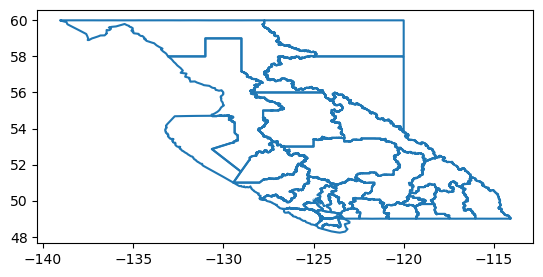

In [82]:
polys['geometry'].boundary.plot()

In [83]:
polys

,Name,Description,geometry
0,Bulkey-Nechako,51,"POLYGON ((-123.42551 53.48487, -123.44910 53.4..."
1,Cariboo,41,"POLYGON ((-122.07361 53.44866, -121.57252 53.4..."
2,Fraser-Fort George,53,"POLYGON ((-123.54184 53.98767, -123.54138 53.9..."
3,Kitimat-Stikine,49,"POLYGON ((-127.69482 55.69715, -127.69503 55.6..."
4,Peace River,55,"POLYGON ((-120.00130 58.00001, -120.00130 57.9..."
5,North Coast,47,"POLYGON ((-129.37605 54.30253, -129.37605 54.3..."
6,Central Okanagan,35,"POLYGON ((-119.66183 49.75896, -119.67325 49.7..."
7,Fraser Valley,9,"POLYGON ((-121.07509 49.35381, -121.07460 49.3..."
8,Greater Vancouver,15,"POLYGON ((-122.77888 49.56987, -122.77886 49.5..."
9,Okanagan-Similkameen,7,"POLYGON ((-120.85136 49.00031, -120.85120 49.0..."


In [84]:
data

,FIRE_CAUSE,LATITUDE,LONGITUDE,SIZE_HA,Year,Month,Weather City,points
0,Lightning,52.7163,-120.8649,0.009,2014,08,Williams Lake,POINT (-120.86490 52.71630)
1,Lightning,51.3333,-120.8167,0.009,2003,07,Williams Lake,POINT (-120.81670 51.33330)
2,Person,55.7837,-120.9953,2.500,2003,09,Dawson Creek,POINT (-120.99530 55.78370)
3,Lightning,51.1633,-118.9430,0.009,2007,07,Nakusp,POINT (-118.94300 51.16330)
4,Lightning,54.8516,-127.6553,0.009,2009,07,Smithers,POINT (-127.65530 54.85160)
...,...,...,...,...,...,...,...,...
35006,Person,49.3728,-116.0612,29.000,2021,07,Sparwood,POINT (-116.06120 49.37280)
35007,Lightning,48.5600,-124.2433,0.300,2021,07,Vancouver,POINT (-124.24330 48.56000)
35008,Lightning,50.3275,-120.3483,0.100,2021,07,Penticton,POINT (-120.34830 50.32750)
35009,Lightning,50.4047,-115.8580,0.009,2021,07,Sparwood,POINT (-115.85800 50.40470)


Next, only the fires from the years 2000 and above are taken, as well as assiging each point to it's correct development region.

In [85]:
for i in range(data.shape[0]):
    t_region = polys[polys['geometry'].contains(data.loc[i,'points'])]
    if t_region.size == 3:
        data.loc[i,'Region Name'] = t_region['Name'].item()
        data.loc[i,'Region Number'] = t_region['Description'].item()
    elif t_region.size == 0:
        data.loc[i,'Region Name'] = 'Other'
        data.loc[i,'Region Number'] = -1
    else:
        print('error')

/var/folders/f9/9vn_4nrs38q_5092cm0ssfhm0000gn/T/ipykernel_40132/2057265163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[i,'Region Name'] = t_region['Name'].item()
/var/folders/f9/9vn_4nrs38q_5092cm0ssfhm0000gn/T/ipykernel_40132/2057265163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[i,'Region Number'] = t_region['Description'].item()


In [86]:
data

,FIRE_CAUSE,LATITUDE,LONGITUDE,SIZE_HA,Year,Month,Weather City,points,Region Name,Region Number
0,Lightning,52.7163,-120.8649,0.009,2014,08,Williams Lake,POINT (-120.86490 52.71630),Cariboo,41.0
1,Lightning,51.3333,-120.8167,0.009,2003,07,Williams Lake,POINT (-120.81670 51.33330),Thompson-Nicola,33.0
2,Person,55.7837,-120.9953,2.500,2003,09,Dawson Creek,POINT (-120.99530 55.78370),Peace River,55.0
3,Lightning,51.1633,-118.9430,0.009,2007,07,Nakusp,POINT (-118.94300 51.16330),Columbia-Shuswap,39.0
4,Lightning,54.8516,-127.6553,0.009,2009,07,Smithers,POINT (-127.65530 54.85160),Bulkey-Nechako,51.0
...,...,...,...,...,...,...,...,...,...,...
35006,Person,49.3728,-116.0612,29.000,2021,07,Sparwood,POINT (-116.06120 49.37280),East Kootenay,1.0
35007,Lightning,48.5600,-124.2433,0.300,2021,07,Vancouver,POINT (-124.24330 48.56000),Capital,17.0
35008,Lightning,50.3275,-120.3483,0.100,2021,07,Penticton,POINT (-120.34830 50.32750),Thompson-Nicola,33.0
35009,Lightning,50.4047,-115.8580,0.009,2021,07,Sparwood,POINT (-115.85800 50.40470),East Kootenay,1.0


In [87]:
data2 = data[data['Region Name'] != 'Other'].reset_index(drop=True)
data2.loc[data2['Region Number'].isin([24.0,26.0]), 'Region Name'] = 'Comox + Strathacona'
data2.loc[data2['Region Name'] == 'Comox + Strathacona', 'Region Number'] = 25.0
data2.loc[data2['Region Number'].isin([51.0,57.0]), 'Region Name'] = 'Bulkley-Nechako + Stikine'
data2.loc[data2['Region Name'] == 'Bulkley-Nechako + Stikine', 'Region Number'] = 51.0

In [88]:
data2

,FIRE_CAUSE,LATITUDE,LONGITUDE,SIZE_HA,Year,Month,Weather City,points,Region Name,Region Number
0,Lightning,52.7163,-120.8649,0.009,2014,08,Williams Lake,POINT (-120.86490 52.71630),Cariboo,41.0
1,Lightning,51.3333,-120.8167,0.009,2003,07,Williams Lake,POINT (-120.81670 51.33330),Thompson-Nicola,33.0
2,Person,55.7837,-120.9953,2.500,2003,09,Dawson Creek,POINT (-120.99530 55.78370),Peace River,55.0
3,Lightning,51.1633,-118.9430,0.009,2007,07,Nakusp,POINT (-118.94300 51.16330),Columbia-Shuswap,39.0
4,Lightning,54.8516,-127.6553,0.009,2009,07,Smithers,POINT (-127.65530 54.85160),Bulkley-Nechako + Stikine,51.0
...,...,...,...,...,...,...,...,...,...,...
34986,Person,49.3728,-116.0612,29.000,2021,07,Sparwood,POINT (-116.06120 49.37280),East Kootenay,1.0
34987,Lightning,48.5600,-124.2433,0.300,2021,07,Vancouver,POINT (-124.24330 48.56000),Capital,17.0
34988,Lightning,50.3275,-120.3483,0.100,2021,07,Penticton,POINT (-120.34830 50.32750),Thompson-Nicola,33.0
34989,Lightning,50.4047,-115.8580,0.009,2021,07,Sparwood,POINT (-115.85800 50.40470),East Kootenay,1.0


In [104]:
data3 = data2.copy()

In [90]:
data3['Year'] = data3['Year'].astype(int)
data3['Month'] = data3['Month'].astype(int)
data3['Region Number'] = data3['Region Number'].astype(int)

In [91]:
data3

,FIRE_CAUSE,LATITUDE,LONGITUDE,SIZE_HA,Year,Month,Weather City,points,Region Name,Region Number
0,Lightning,52.7163,-120.8649,0.009,2014,8,Williams Lake,POINT (-120.86490 52.71630),Cariboo,41
1,Lightning,51.3333,-120.8167,0.009,2003,7,Williams Lake,POINT (-120.81670 51.33330),Thompson-Nicola,33
2,Person,55.7837,-120.9953,2.500,2003,9,Dawson Creek,POINT (-120.99530 55.78370),Peace River,55
3,Lightning,51.1633,-118.9430,0.009,2007,7,Nakusp,POINT (-118.94300 51.16330),Columbia-Shuswap,39
4,Lightning,54.8516,-127.6553,0.009,2009,7,Smithers,POINT (-127.65530 54.85160),Bulkley-Nechako + Stikine,51
...,...,...,...,...,...,...,...,...,...,...
34986,Person,49.3728,-116.0612,29.000,2021,7,Sparwood,POINT (-116.06120 49.37280),East Kootenay,1
34987,Lightning,48.5600,-124.2433,0.300,2021,7,Vancouver,POINT (-124.24330 48.56000),Capital,17
34988,Lightning,50.3275,-120.3483,0.100,2021,7,Penticton,POINT (-120.34830 50.32750),Thompson-Nicola,33
34989,Lightning,50.4047,-115.8580,0.009,2021,7,Sparwood,POINT (-115.85800 50.40470),East Kootenay,1


In [92]:
area.columns = ['Region Number','Region Name', 'Region Area']
area['Region Area'] = area['Region Area']*100

In [93]:
area

,Region Number,Region Name,Region Area
0,1,East Kootenay,2754184.0
1,3,Central Kootenay,2209494.0
2,5,Kootenay Boundary,808452.0
3,7,Okanagan-Similkameen,1041168.0
4,9,Fraser Valley,1333528.0
5,15,Greater Vancouver,288268.0
6,17,Capital,234049.0
7,19,Cowichan Valley,347452.0
8,21,Nanaimo,203804.0
9,23,Alberni-Clayoquot,658915.0


In [110]:
data4 = pd.merge(data3, region_areas, on=['Region Number','Region Name'], how='left')
data4 = data4.drop('points', axis=1)

In [111]:
data4['Lightning Dummy'] = 0
data4.loc[data4['FIRE_CAUSE'] == 'Lightning', 'Lightning Dummy'] = 1

In [112]:
data4

,FIRE_CAUSE,LATITUDE,LONGITUDE,SIZE_HA,Year,Month,Weather City,Region Name,Region Number,Region Area,Lightning Dummy
0,Lightning,52.7163,-120.8649,0.009,2014,08,Williams Lake,Cariboo,41.0,8060975.0,1
1,Lightning,51.3333,-120.8167,0.009,2003,07,Williams Lake,Thompson-Nicola,33.0,4444942.0,1
2,Person,55.7837,-120.9953,2.500,2003,09,Dawson Creek,Peace River,55.0,11738755.0,0
3,Lightning,51.1633,-118.9430,0.009,2007,07,Nakusp,Columbia-Shuswap,39.0,2892919.0,1
4,Lightning,54.8516,-127.6553,0.009,2009,07,Smithers,Bulkley-Nechako + Stikine,51.0,19202453.0,1
...,...,...,...,...,...,...,...,...,...,...,...
34986,Person,49.3728,-116.0612,29.000,2021,07,Sparwood,East Kootenay,1.0,2754184.0,0
34987,Lightning,48.5600,-124.2433,0.300,2021,07,Vancouver,Capital,17.0,234049.0,1
34988,Lightning,50.3275,-120.3483,0.100,2021,07,Penticton,Thompson-Nicola,33.0,4444942.0,1
34989,Lightning,50.4047,-115.8580,0.009,2021,07,Sparwood,East Kootenay,1.0,2754184.0,1


In [113]:
data5 = data4.copy()

In [114]:
data5 = data5[data5['FIRE_CAUSE'] != 'Lightning'].reset_index(drop=True).drop('Lightning Dummy', axis=1)

In [115]:
data5

,FIRE_CAUSE,LATITUDE,LONGITUDE,SIZE_HA,Year,Month,Weather City,Region Name,Region Number,Region Area
0,Person,55.7837,-120.9953,2.500,2003,09,Dawson Creek,Peace River,55.0,11738755.0
1,Person,56.1209,-120.5031,1.800,2015,07,Dawson Creek,Peace River,55.0,11738755.0
2,Person,51.8789,-120.4961,0.009,2002,07,Williams Lake,Cariboo,41.0,8060975.0
3,Person,49.9964,-120.9117,0.100,2018,09,Penticton,Thompson-Nicola,33.0,4444942.0
4,Person,50.0178,-120.6202,0.100,2001,07,Penticton,Thompson-Nicola,33.0,4444942.0
...,...,...,...,...,...,...,...,...,...,...
14331,Person,49.5202,-121.2050,0.009,2021,07,Penticton,Fraser Valley,9.0,1333528.0
14332,Person,50.9486,-119.6703,0.030,2021,07,Penticton,Thompson-Nicola,33.0,4444942.0
14333,Person,50.0750,-120.7764,0.009,2021,07,Penticton,Thompson-Nicola,33.0,4444942.0
14334,Person,49.3398,-120.0636,0.300,2021,07,Penticton,Okanagan-Similkameen,7.0,1041168.0


In [117]:
data4.to_csv('clean_fire_data.csv', index=False)

In [118]:
data5.to_csv('NO_LIGHTNING_clean_fire_data.csv', index=False)